# 

# Computational Social Science Project #2 

**Enter your Name:** **Marco Schürer**

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [78]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [79]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [80]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [81]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:\n', diabetes.dtypes)

data types:
 County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total populatio

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [82]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

#print(diabetes[~diabetes[______].str.isnumeric()][______].unique()) 

['Suppressed']


In [83]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique())


['No Data']


In [84]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique())


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [85]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype("int64") 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype("int64")

# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype("int64")


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype("float")

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [86]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [87]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present


count           mean  \
Diabetes_Number                                     3112.0       0.092857   
Obesity_Number                                      3112.0       0.251666   
Physical_Inactivity_Number                          3112.0       0.200861   
sex and age_total population_65 years and over_...  3112.0      84.275643   
race_total population                               3112.0  103682.624036   
race_total population_one race                      3112.0       0.976059   
race_total population_two or more races             3112.0       0.023941   
race_total population_one race_1                    3112.0       0.976059   
race_total population_one race_white                3112.0       0.831107   
race_total population_one race_black or african...  3112.0       0.090215   
race_total population_one race_american indian ...  3112.0       0.019398   
race_total population_one race_american indian ...  3112.0       0.001791   
race_total population_one race_american indian ...  3112.0       0.001338   
race_total population_one race_american indian ...  3112.0       0.001229   
race_total population_one race_american indian ...  3112.0       0.003315   
race_total population_one race_asian                3112.0       0.013749   
race_total population_one race_asian_asian indian   3112.0       0.002628   
race_total population_one race_asian_chinese        3112.0       0.002644   
race_total population_one race_asian_filipino       3112.0       0.002744   
race_total population_one race_asian_japanese       3112.0       0.000707   
race_total population_one race_asian_korean         3112.0       0.001174   
race_total population_one race_asian_vietnamese     3112.0       0.001255   
race_total population_one race_asian_other asian    3112.0       0.002598   
race_total population_one race_native hawaiian ...  3112.0       0.000874   
race_total population_one race_native hawaiian ...  3112.0       0.000303   
race_total population_one race_native hawaiian ...  3112.0       0.000142   
race_total population_one race_native hawaiian ...  3112.0       0.000134   
race_total population_one race_native hawaiian ...  3112.0       0.000295   
race_total population_one race_some other race      3112.0       0.020716   
race_total population_two or more races_1           3112.0       0.023941   
race_total population_two or more races_white a...  3112.0       0.006444   
race_total population_two or more races_white a...  3112.0       0.008618   
race_total population_two or more races_white a...  3112.0       0.003021   
race_total population_two or more races_black o...  3112.0       0.000652   
race alone or in combination with one or more o...  3112.0       1.000000   
race alone or in combination with one or more o...  3112.0       0.852907   
race alone or in combination with one or more o...  3112.0       0.098875   
race alone or in combination with one or more o...  3112.0       0.029923   
race alone or in combination with one or more o...  3112.0       0.018213   
race alone or in combination with one or more o...  3112.0       0.002067   
race alone or in combination with one or more o...  3112.0       0.023626   
hispanic or latino and race_total population        3112.0       1.000000   
hispanic or latino and race_total population_hi...  3112.0       0.093201   
hispanic or latino and race_total population_hi...  3112.0       0.069331   
hispanic or latino and race_total population_hi...  3112.0       0.005656   
hispanic or latino and race_total population_hi...  3112.0       0.001568   
hispanic or latino and race_total population_hi...  3112.0       0.016645   
hispanic or latino and race_total population_no...  3112.0       0.906799   
hispanic or latino and race_total population_no...  3112.0       0.765065   
hispanic or latino and race_total population_no...  3112.0       0.088817   
hispanic or latino and race_total population_no...  3112.0       0.018016   
hispanic or latino and race_total population_no..

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [88]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'race_total population_one race_1']

In [89]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [90]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0                       0.226902   
1                       0.192324   
2                       0.210651   
3                       0.258667   
4                       0.249198   
...                          ...   
3215                    0.170410   
3216                    0.086951   
3217                    0.170751   
3218                    0.210112   
3219                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                                  76.5                                  
1                                                  86.6                                  
2                                                  76.2                                  
3                                                  80.5                                  
4                                                  79.7                                  
...                                                 ...                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
0                     55200                        0.981341   
1                    208107                        0.982836   
2                     25782                        0.986308   
3                     22527                        0.991699   
4                     57645                        0.983780   
...                     ...                             ...   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
0                                    0.018659   
1                                    0.017164   
2                                    0.013692   
3                                    0.008301   
4                                    0.016220   
...                                       ...   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
0                                 0.768786   
1                                 0.862662   
2                                 0.473819   
3           

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

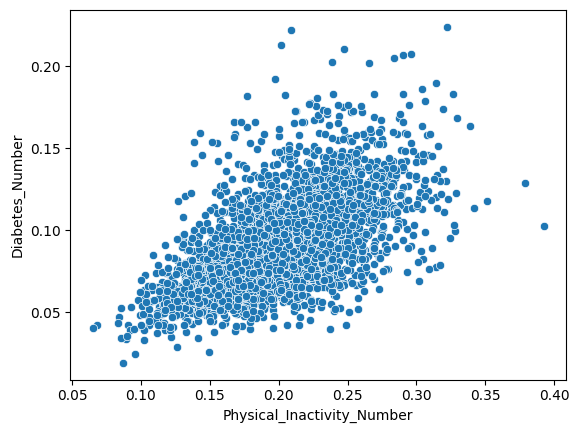

In [91]:
#
# EDA #1 and interpretations in this section 
#-----------

sns.scatterplot(x = "Physical_Inactivity_Number",
                y = "Diabetes_Number",
                data = diabetes);


#### Interpretation:
This scatter plot shows the relationship between obesity and diabetes rates across counties. A positive correlation would suggest that higher obesity rates are associated with higher diabetes rates, which could highlight the importance of obesity management in diabetes prevention efforts. Policymakers could use this insight to design targeted interventions that address both obesity and diabetes in high-risk areas.

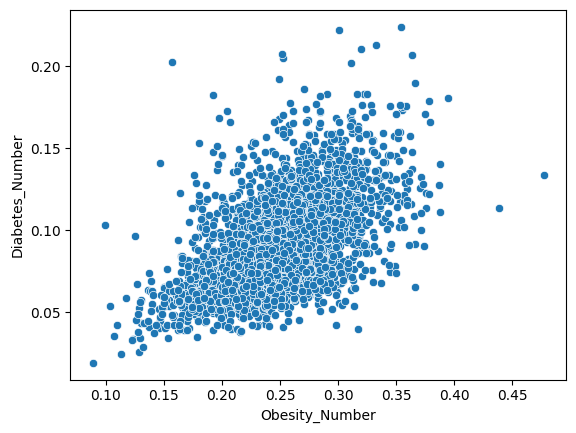

In [92]:
#
# EDA #2 and interpretations in this section 
#-----------
sns.scatterplot(x = "Obesity_Number",
                y = "Diabetes_Number",
                data = diabetes);

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [93]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ["Region"],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

CountyFIPS  Diabetes_Number  Obesity_Number  Physical_Inactivity_Number  \
0      01001         0.093804        0.244366                    0.226902   
1      01003         0.080281        0.233255                    0.192324   
2      01005         0.131875        0.310643                    0.210651   
3      01007         0.105251        0.290052                    0.258667   
4      01009         0.108977        0.246804                    0.249198   
5      01011         0.224208        0.353748                    0.321967   
6      01013         0.145318        0.349513                    0.300974   
7      01015         0.127648        0.298580                    0.234140   
8      01017         0.141518        0.324425                    0.220570   
9      01019         0.122848        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.2057

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [94]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean["Diabetes_Number"]

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(columns=["Diabetes_Number","race alone or in combination with one or more other races_total population"])

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [95]:
#
# Feature selection
#-----------



In [96]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.80,      # specify proportional split for training
                                                    test_size=0.20)       # specify proportional split for test

In [97]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.75,      # specify proportional split for training
                                                    test_size=0.25)       # specify proportional split for test

In [98]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

#### MODEL DESCRIPTION(S) for policy-makers:

**OLS**: Ordinary Least Squares (OLS) is a straightforward approach to understanding the relationships between variables, creating a “best-fit” line that shows how changes in certain factors are associated with changes in an outcome of interest. This method is transparent and interpretable, providing insights into how each factor directly impacts the outcome. However, OLS can sometimes overemphasize minor patterns in the data, especially when there are many related variables, which may reduce its accuracy in new scenarios. Despite this limitation, OLS serves as a foundational model, helping us establish a baseline understanding without additional complexity.

**Ridge Regression**: Ridge regression builds on OLS by adding a mechanism to prevent the model from placing too much importance on any one variable, particularly when multiple factors are highly related. This technique improves the model’s robustness, making it better suited for forecasting and adapting to new data. By slightly reducing the influence of less impactful variables, Ridge provides a more balanced view that reduces the risk of overfitting, ensuring the model’s recommendations are grounded in broader trends rather than isolated patterns. This approach is especially valuable when data includes many interrelated variables.

**Elastic Net**: Elastic Net combines the strengths of Ridge with an additional feature-selection capability, allowing it to prioritize the most important factors while minimizing or even removing the influence of less relevant ones. This model is particularly well-suited for complex datasets with highly interconnected variables, as it not only stabilizes the analysis but also streamlines it by focusing on the most impactful factors. Elastic Net provides a flexible yet precise approach, making it effective for policy analysis that requires both reliable forecasts and a simplified model that highlights key drivers of outcomes.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Ordinary Least Squares (OLS)

In [99]:
# Get the Model going
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predictions and metrics
y_pred_train_ols = ols_model.predict(X_train)
ols_r2 = r2_score(y_train, y_pred_train_ols)
ols_mse = mean_squared_error(y_train, y_pred_train_ols)

print("OLS Training R^2:", ols_r2)
print("OLS Training MSE:", ols_mse)

OLS Training R^2: 0.534435479269571
OLS Training MSE: 0.00036069544598416373


##### Explanation
###### Training R²: 0.534
1. This R² value indicates that 53.4% of the variance in the target variable is explained by the OLS model on the training set. While this is a modest fit, it suggests that the model is capturing some of the patterns in the data, but not all.
2. An R² of around 0.5 means that there’s room for improvement, as nearly half of the variance remains unexplained by the model. However, this is typical for many real-world datasets, where perfect fit is challenging.

###### MSE: 0.000361
1. The low MSE value indicates that the average squared difference between the predicted and actual values is quite small, suggesting that the model’s predictions are reasonably close to the observed values.
2. A lower MSE generally indicates better accuracy, but it’s essential to compare this with other models to interpret its relative performance.

##### Interpretation

OLS serves as a baseline model without regularization, meaning it fits the data based solely on minimizing errors without any penalty for model complexity. The moderate R² value suggests that the model captures some trends in the data but could be improved by regularization to prevent overfitting or handle multicollinearity.

#### Model 2: Ridge Model 

In [100]:
# Set up and tuning
ridge_param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, cv=5)
ridge_grid.fit(X_train, y_train)

# Best Ridge model (I found using Google)
ridge_model = ridge_grid.best_estimator_
y_pred_train_ridge = ridge_model.predict(X_train)
ridge_r2 = r2_score(y_train, y_pred_train_ridge)
ridge_mse = mean_squared_error(y_train, y_pred_train_ridge)

print("Best Ridge Alpha:", ridge_grid.best_params_['alpha'])
print("Ridge Training R^2:", ridge_r2)
print("Ridge Training MSE:", ridge_mse)



Best Ridge Alpha: 100
Ridge Training R^2: 0.5267324518716785
Ridge Training MSE: 0.0003666633554338613


##### Explanation
###### Training R²: 0.527
1. With an R² of 52.7%, the Ridge model performs slightly worse than OLS on the training set in terms of explained variance.
2. This slight decrease in R² compared to OLS might be due to the regularization introduced by Ridge, which constrains the coefficients to prevent overfitting.

###### MSE: 0.000367
1. The MSE for Ridge is 0.000367, which is marginally higher than the MSE for OLS. This indicates that Ridge is slightly less accurate on the training set compared to OLS.
2. However, the difference is small, and regularization may help Ridge perform better on the test set or with unseen data by reducing variance.

###### Best Alpha: 100
The best alpha (regularization strength) found through tuning is 100, which is relatively high. This suggests that the model is applying strong regularization, likely to address multicollinearity or reduce the effect of overfitting by shrinking the coefficients.

##### Interpretation

Ridge has a very similar performance to OLS on the training data but with slightly lower R² and slightly higher MSE. The high alpha value shows that Ridge is adding a significant regularization penalty, which might help it generalize better on test data, even if it sacrifices a bit of training accuracy.

#### Model 3:  Elastic Net Model

In [101]:
# Set up and tuning 
elasticnet_param_grid = {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.2, 0.5, 0.8]}
elasticnet_grid = GridSearchCV(ElasticNet(), elasticnet_param_grid, cv=5)
elasticnet_grid.fit(X_train, y_train)

# Best Elastic Net model (Found with Google)
elastic_net_model = elasticnet_grid.best_estimator_
y_pred_train_enet = elastic_net_model.predict(X_train)
enet_r2 = r2_score(y_train, y_pred_train_enet)
enet_mse = mean_squared_error(y_train, y_pred_train_enet)

print("Best ElasticNet Alpha:", elasticnet_grid.best_params_['alpha'])
print("Best ElasticNet L1 Ratio:", elasticnet_grid.best_params_['l1_ratio'])
print("Elastic Net Training R^2:", enet_r2)
print("Elastic Net Training MSE:", enet_mse)

Best ElasticNet Alpha: 0.01
Best ElasticNet L1 Ratio: 0.2
Elastic Net Training R^2: 0.470973424700023
Elastic Net Training MSE: 0.00040986258191651816


##### Explanation
###### Training R²: 0.471
1. With an R² of 47.1%, Elastic Net explains slightly less variance in the training data compared to both OLS and Ridge. This lower R² suggests that Elastic Net might not be capturing the data’s patterns as effectively in this scenario.
2. However, this could also mean that Elastic Net is better at generalizing, as it’s less focused on capturing every detail in the training data.

###### MSE: 0.000410
1. Elastic Net has the highest MSE on the training data among the three models, at 0.000410. This suggests that its predictions are, on average, slightly further from the actual values compared to OLS and Ridge.

###### Best Alpha: 0.01 and Best L1 Ratio: 0.2
1. A low alpha value of 0.01 indicates light regularization, while an L1 ratio of 0.2 means that the model is primarily using L2 regularization (like Ridge) with a small component of L1 regularization (like Lasso).
2. The L1 component helps to drive some coefficients toward zero, potentially simplifying the model, but the main focus is on Ridge-like regularization.

##### Interpretation

Elastic Net combines the benefits of both Ridge and Lasso, but in this case, it seems to underperform slightly on the training data. The relatively low R² and high MSE suggest that it may not be the best model for capturing detailed patterns in the training set, though it might generalize better to test data due to its regularization balance.

In [102]:
# Summary data for each model
summary_data = {
    "Model": ["OLS", "Ridge", "Elastic Net"],
    "Training R^2": [ols_r2, ridge_r2, enet_r2],
    "Training MSE": [ols_mse, ridge_mse, enet_mse],
    "Best Alpha": ["N/A", ridge_grid.best_params_['alpha'], elasticnet_grid.best_params_['alpha']],
    "Best L1 Ratio": ["N/A", "N/A", elasticnet_grid.best_params_['l1_ratio']]
}

summary_df = pd.DataFrame(summary_data)

# Summary Table
summary_df

Model  Training R^2  Training MSE Best Alpha Best L1 Ratio
0          OLS      0.534435      0.000361        N/A           N/A
1        Ridge      0.526732      0.000367        100           N/A
2  Elastic Net      0.470973      0.000410       0.01           0.2

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [103]:
#
# Predict on validation data
y_pred_val_ols = ols_model.predict(X_validate)
y_pred_val_ridge = ridge_model.predict(X_validate)
y_pred_val_enet = elastic_net_model.predict(X_validate)

# Calculate R^2 and MSE for each model on the validation set
print("OLS Validation R^2:", r2_score(y_validate, y_pred_val_ols))
print("OLS Validation MSE:", mean_squared_error(y_validate, y_pred_val_ols))

print("Ridge Validation R^2:", r2_score(y_validate, y_pred_val_ridge))
print("Ridge Validation MSE:", mean_squared_error(y_validate, y_pred_val_ridge))

print("Elastic Net Validation R^2:", r2_score(y_validate, y_pred_val_enet))
print("Elastic Net Validation MSE:", mean_squared_error(y_validate, y_pred_val_enet))



OLS Validation R^2: 0.20396342827039227
OLS Validation MSE: 0.0006627547616612103
Ridge Validation R^2: 0.4598322932924127
Ridge Validation MSE: 0.00044972647291596063
Elastic Net Validation R^2: 0.4398659429289028
Elastic Net Validation MSE: 0.00046634982195086785


##### Explanation
###### OLS
**R²: 0.204:** This low R² value suggests that OLS is explaining only about 20% of the variance in the validation data, indicating a poor fit.
**MSE: 0.000662:** OLS has the highest MSE among the models, meaning its predictions are, on average, further from the actual values. This suggests OLS is overfitting to the training data and struggling to generalize.

###### Ridge Regression
**R²: 0.459:** Ridge performs significantly better than OLS, explaining about 46% of the variance in the validation data. The higher R² and lower MSE suggest that Ridge’s regularization is helping it generalize better.
**MSE: 0.000450:** Ridge has the lowest MSE, indicating that its predictions are closer to the actual values compared to the other models. This suggests Ridge is the best-performing model on the validation set.

###### Elastic Net
**R²: 0.440:** Elastic Net also performs better than OLS, explaining about 44% of the variance. However, its R² is slightly lower than Ridge, suggesting it doesn’t capture the relationships as effectively.
**MSE: 0.000466:** The MSE for Elastic Net is close to that of Ridge but slightly higher, indicating that it’s not quite as accurate on the validation set.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [104]:
# Get the coefficients of the Ridge model
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)

# Sort coefficients by absolute value to find the most and least important features
ridge_coefs_sorted = ridge_coefs.abs().sort_values()

# Display the least important features (you can choose a threshold for unimportance)
print("Least important features:\n", ridge_coefs_sorted.head())

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
ridge_model.fit(X_train_scaled, y_train)

# Re-evaluate coefficients after scaling
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)
ridge_coefs_sorted = ridge_coefs.abs().sort_values()
print(ridge_coefs_sorted.head())


Least important features:
 CountyFIPS                                                                                                                                              6.970793e-09
race_total population_two or more races                                                                                                                 1.762907e-05
race_total population_one race                                                                                                                          1.762907e-05
hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone                                    3.238008e-05
hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races    4.089722e-05
dtype: float64
race_total population                          0.000011
race_total population_two or more races        0.000016
race_total population

In [105]:
# List of unimportant features to drop
unimportant_features = [
    'CountyFIPS',
    'race_total population_two or more races',
    'race_total population_one race',
    'hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone',
    'hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races',
    'race_total population',
    'race_total population_one race_asian_korean',
    'sex and age_total population_55 to 59 years'
]

# Drop unimportant features from datasets
X_train_reduced = X_train.drop(columns=unimportant_features)
X_val_reduced = X_validate.drop(columns=unimportant_features)
X_test_reduced = X_test.drop(columns=unimportant_features)

In [106]:
# Reinitialize the Ridge model with the best alpha found previously
ridge_model_retrained = Ridge(alpha=ridge_grid.best_params_['alpha'])

# Train on the reduced training set
ridge_model_retrained.fit(X_train_reduced, y_train)

Ridge(alpha=100)

In [107]:
# Predict on the test set with the retrained Ridge model
y_pred_test_ridge_retrained = ridge_model_retrained.predict(X_test_reduced)

# Calculate R^2 and MSE for the test set
test_r2_ridge_retrained = r2_score(y_test, y_pred_test_ridge_retrained)
test_mse_ridge_retrained = mean_squared_error(y_test, y_pred_test_ridge_retrained)

print("Ridge (Reduced Features) Test R^2:", test_r2_ridge_retrained)
print("Ridge (Reduced Features) Test MSE:", test_mse_ridge_retrained)

Ridge (Reduced Features) Test R^2: 0.4757693587649753
Ridge (Reduced Features) Test MSE: 0.0003982113229966675


##### Final Model Results
**Test R²: 0.476**
This R² value indicates that the refined Ridge model with reduced features explains about 47.6% of the variance in the test data. This is a moderate fit, showing that the model captures nearly half of the data’s variability.
Compared to the training and validation results, this R² suggests that the model generalizes reasonably well and isn’t overfitting significantly.

**Test MSE: 0.000398**
The low MSE value indicates that, on average, the squared difference between the predicted and actual values is quite small, which means the model’s predictions are close to the actual test set values.
This MSE is consistent with the validation MSE, suggesting that the reduced-feature Ridge model performs well on unseen data.

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [109]:
#
# Run cross-validation
# Define the scoring metrics
scoring_r2 = 'r2'
scoring_mse = make_scorer(mean_squared_error, greater_is_better=False)

# Perform 5-fold cross-validation for R^2
cv_r2_scores = cross_val_score(ridge_model_retrained, X_train_reduced, y_train, cv=5, scoring=scoring_r2)
# Perform 5-fold cross-validation for MSE
cv_mse_scores = cross_val_score(ridge_model_retrained, X_train_reduced, y_train, cv=5, scoring=scoring_mse)

# Calculate the mean and standard deviation for R^2 and MSE
mean_r2 = cv_r2_scores.mean()
std_r2 = cv_r2_scores.std()
mean_mse = -cv_mse_scores.mean()  # negate MSE because scoring function returns negative values
std_mse = cv_mse_scores.std()

print(f"Cross-Validation R^2: Mean = {mean_r2:.4f}, Std = {std_r2:.4f}")
print(f"Cross-Validation MSE: Mean = {mean_mse:.6f}, Std = {std_mse:.6f}")



Cross-Validation R^2: Mean = 0.4980, Std = 0.0402
Cross-Validation MSE: Mean = 0.000388, Std = 0.000031


#### Cross-Validation Interpretation
##### Cross-Validation R²:
1. **Mean R² = 0.498:** On average, the model explains about 49.8% of the variance across the 5 folds. This aligns closely with the R² from the test set (around 47.6%), indicating that the model is consistent and performs similarly on different subsets of the data.
2. **Std R² = 0.0402:** The relatively low standard deviation suggests that the model's performance is stable across the folds, meaning it has consistent predictive power across different data splits.

##### Cross-Validation MSE:
1. **Mean MSE = 0.000388:** The average MSE across the folds is very close to the MSE from the test set (0.000398), which means that the model’s prediction errors are similarly low across various data subsets.
2. **Std MSE = 0.000031:** The small standard deviation for MSE indicates that the prediction accuracy doesn’t vary much across folds, which further confirms the model’s robustness.

#### Final Summary for Cross-Validation
The results from cross-validation show that the Ridge model with reduced features generalizes well and performs consistently across different subsets of the data. This consistency in both R² and MSE across folds suggests that:

The model is stable and not overly sensitive to specific data splits.
It has low variance in its predictions, which is a desirable quality for deployment.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

The bias-variance tradeoff is about balancing a model’s simplicity and flexibility. A model with high bias is too simplistic, missing key patterns, while high variance means the model is overly complex and fits random noise in the data. This balance is critical to building models that generalize well to new data. In our project, using Ridge regression helped manage this balance, creating a model that performs reliably on both current and future data.

2. Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting happens when a model learns specific details and noise in the training data, reducing its effectiveness on new data. It matters because an overfit model performs poorly in real-world scenarios. We addressed overfitting by applying regularization techniques like Ridge regression, which control model complexity and enhance generalization.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

Our analysis using the Ridge model with reduced features highlighted certain patterns in health-related data, allowing for insights that could guide targeted interventions. The model demonstrated stable performance across validation and test sets, suggesting it can generalize well to new data. Based on the patterns observed, I would recommend prioritizing counties where key health predictors, such as obesity rates, age distribution, and specific socioeconomic factors, are prominent. These areas would benefit most from a pilot program aimed at addressing specific health needs efficiently.

If we factor in demographic characteristics such as race, gender, or age, the prioritization of counties might shift. Including these features could reveal disparities or needs among certain populations, leading to a more targeted approach in regions with higher vulnerability. However, I share concerns about the quality and availability of data for some of these groups. Variables with very low coefficients may not fully capture the complexity of vulnerable populations, which could unintentionally bias the model’s recommendations. Expanding the dataset, potentially with inputs from local health organizations or additional demographic sources, would strengthen the model’s inclusivity.

Regarding deployment, while the model is robust, I’d advise cautious optimism. I’m confident in its current stability, but I would recommend continuous monitoring and refinement to address any limitations. The absence of socioeconomic factors like income is a concern, as income is strongly linked to health outcomes. Adding such variables in future iterations would likely improve accuracy and equity. Overall, while the model offers a promising foundation, refining the data and incorporating additional variables would enhance its suitability for real-world applications, especially in addressing the needs of underserved communities. Thank you for the opportunity to reflect on these critical considerations.